In [1]:
import os
import glob
import random

import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2


learning_rate = 0.001
batch_size = 10
epochs = 10


device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [2]:
train_path = 'D:/Programming/AP_Lab5/train'
test_path = 'D:/Programming/AP_Lab5/test'
val_path = 'D:/Programming/AP_Lab5/val'

path1 = "bay_horse.csv"
path2 = "zebra.csv"

dfs = []
tmp1 = pd.read_csv(path1, sep=';', header=None)
tmp1.drop(0, axis=1, inplace=True)

dfs.append(tmp1)
tmp2 = pd.read_csv(path2, sep=';', header=None)
tmp2.drop(0, axis=1, inplace=True)
dfs.append(tmp2)
df = pd.concat(dfs)

df.reset_index(drop=True, inplace=True)

df.rename(columns={1: 'absolute_path', 2: 'rel_path', 3: 'img_class'}, inplace=True)
print(df)


if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)



def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_path[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.img_class[i]}.{i}.jpg'), image)


def load_val(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_path[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)

def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_path[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)



for i in range(768):
    load_train(df, train_path, i)
for i in range(961,1729):
    load_train(df, train_path, i)
for i in range(768,865):
    load_test(df,test_path,i)
for i in range(1729,1826):
    load_test(df,test_path,i)
for i in range(865,960):
    load_val(df,val_path,i)
for i in range(1826,1920):
    load_val(df,val_path,i)



train_list = glob.glob(os.path.join(train_path, '*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))
val_list = glob.glob(os.path.join(val_path, '*.jpg'))

# split our data into train and test sets
train_list, val_list = train_test_split(train_list, test_size=0.1)

                                          absolute_path  \
0     D:\Programming\AP_Lab2\dataset\bay_horse\0000.jpg   
1     D:\Programming\AP_Lab2\dataset\bay_horse\0001.jpg   
2     D:\Programming\AP_Lab2\dataset\bay_horse\0002.jpg   
3     D:\Programming\AP_Lab2\dataset\bay_horse\0003.jpg   
4     D:\Programming\AP_Lab2\dataset\bay_horse\0004.jpg   
...                                                 ...   
2449      D:\Programming\AP_Lab2\dataset\zebra\1211.jpg   
2450      D:\Programming\AP_Lab2\dataset\zebra\1212.jpg   
2451      D:\Programming\AP_Lab2\dataset\zebra\1213.jpg   
2452      D:\Programming\AP_Lab2\dataset\zebra\1214.jpg   
2453      D:\Programming\AP_Lab2\dataset\zebra\1215.jpg   

                        rel_path  img_class  
0     dataset\bay_horse\0000.jpg  bay_horse  
1     dataset\bay_horse\0001.jpg  bay_horse  
2     dataset\bay_horse\0002.jpg  bay_horse  
3     dataset\bay_horse\0003.jpg  bay_horse  
4     dataset\bay_horse\0004.jpg  bay_horse  
...            

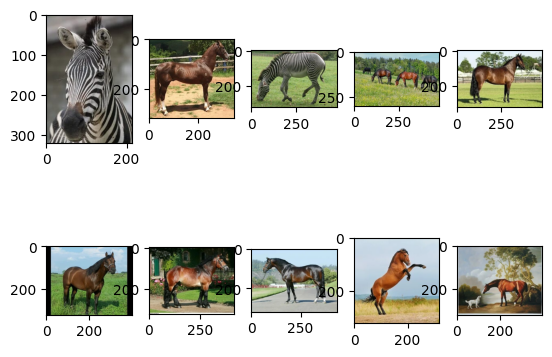

In [3]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

Пишем свёрточную нейронную сеть

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = ConvNet().to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Image Augmentation

In [5]:

train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])


Загрузим сеты картинок

In [6]:
from PIL import Image

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('\\')[-1].split('.')[0]
        
        if label == 'tiger':
            label = 1
        elif label == 'leopard':
            label = 0

        return img_transformed,label


train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

Тесты обучения с разными параметрами batch size и learning rate

Learning rate: 0.001, Batch size: 10
Epoch : 1, train accuracy : 0.9050352573394775, train loss : 0.23071739077568054
Epoch : 1, val_accuracy : 0.921875, val_loss : 0.2735392451286316
Epoch : 2, train accuracy : 0.9093517661094666, train loss : 0.2219756841659546
Epoch : 2, val_accuracy : 0.9156249761581421, val_loss : 0.17267587780952454
Epoch : 3, train accuracy : 0.9366897344589233, train loss : 0.15511225163936615
Epoch : 3, val_accuracy : 0.9624999761581421, val_loss : 0.10683251917362213
Epoch : 4, train accuracy : 0.9302149415016174, train loss : 0.17969922721385956
Epoch : 4, val_accuracy : 0.90625, val_loss : 0.19240255653858185
Epoch : 5, train accuracy : 0.9374091029167175, train loss : 0.1634148806333542
Epoch : 5, val_accuracy : 0.9156249165534973, val_loss : 0.1961083561182022
Epoch : 6, train accuracy : 0.946761429309845, train loss : 0.1436660885810852
Epoch : 6, val_accuracy : 0.956250011920929, val_loss : 0.12475914508104324
Epoch : 7, train accuracy : 0.9388481378555

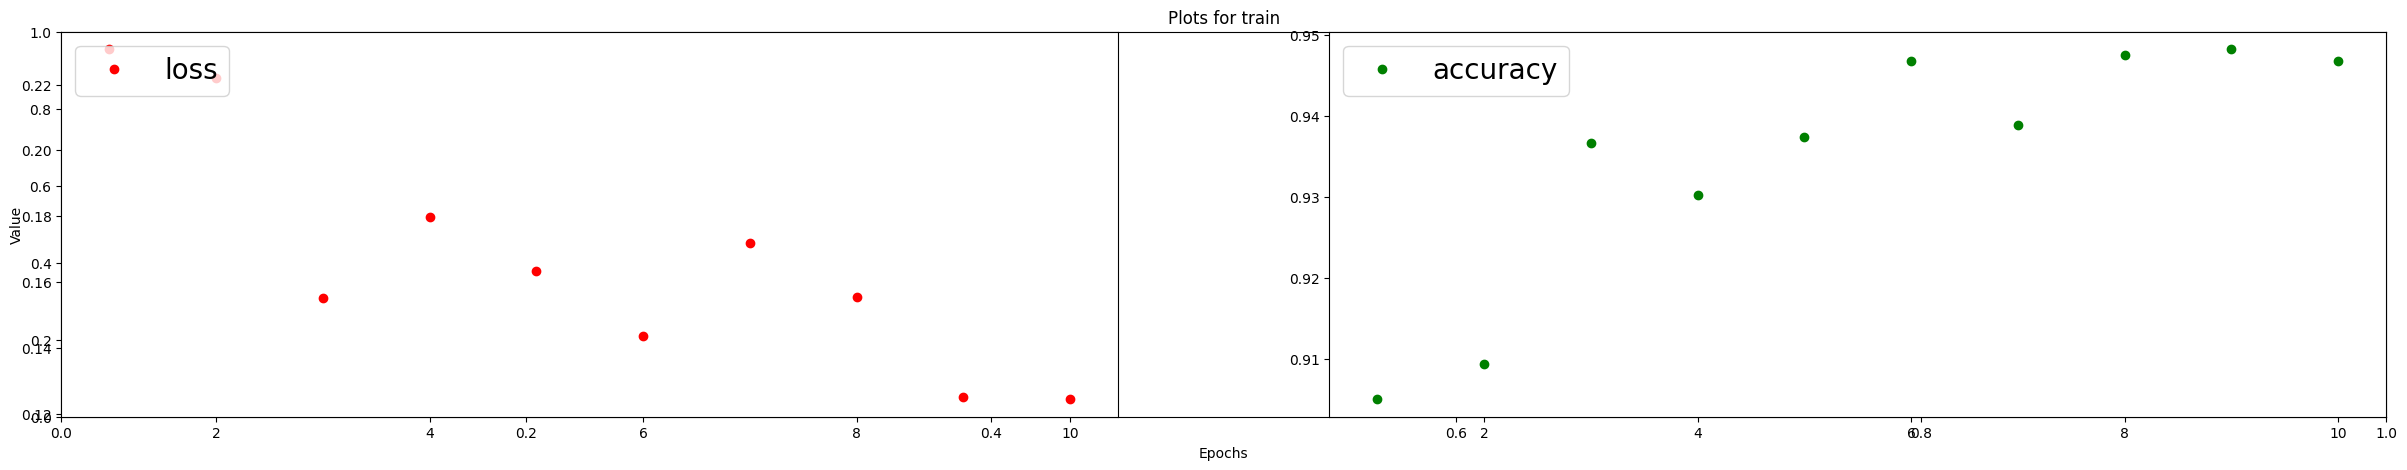

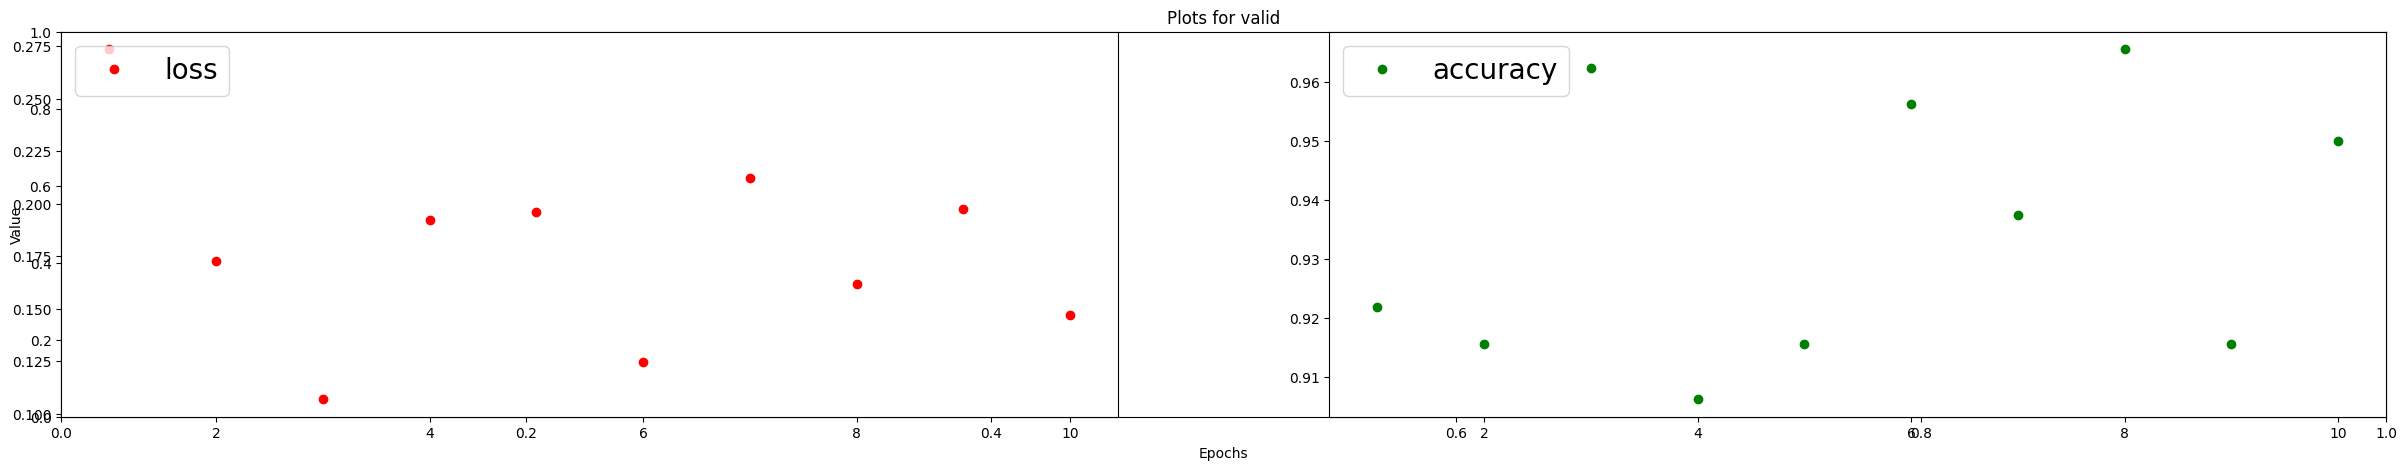

In [9]:
print('Learning rate: 0.001, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

epochs = 10
def train_loop (train_loader, val_loader, epochs):
    val_loss_list = []
    val_accuracy_list = []

    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            
            le = preprocessing.LabelEncoder()
            targets = le.fit_transform(label)
            targets = torch.as_tensor(targets)

            data = data.to(device)
            label = targets.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        loss_list.append(epoch_loss.item())
        accuracy_list.append(epoch_accuracy.item())

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))


        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0

            for data, label in val_loader:

                le = preprocessing.LabelEncoder()
                targets = le.fit_transform(label)
                targets = torch.as_tensor(targets)
                
                data = data.to(device)
                label = targets.to(device)

                val_output = model(data)
                val_loss = criterion(val_output,label)

                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)


            val_loss_list.append(epoch_val_loss.item())
            val_accuracy_list.append(epoch_val_accuracy.item())

            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))


    num_epochs = [i+1 for i in range(epochs)]

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, loss_list, 'ro', label = 'loss')
    plt.legend(loc=2, prop={'size': 20})
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, accuracy_list, 'go', label = 'accuracy')
    plt.legend(loc=2, prop={'size': 20})

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for valid')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, val_loss_list, 'ro', label = 'loss')
    plt.legend(loc=2, prop={'size': 20})
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, val_accuracy_list, 'go', label = 'accuracy')
    plt.legend(loc=2, prop={'size': 20})

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 10
Epoch : 1, train accuracy : 0.9546750783920288, train loss : 0.12127811461687088
Epoch : 1, val_accuracy : 0.8999999165534973, val_loss : 0.24238039553165436
Epoch : 2, train accuracy : 0.9568334221839905, train loss : 0.10932125896215439
Epoch : 2, val_accuracy : 0.9687499403953552, val_loss : 0.09611999243497849
Epoch : 3, train accuracy : 0.9482007026672363, train loss : 0.13134858012199402
Epoch : 3, val_accuracy : 0.953125, val_loss : 0.16103097796440125
Epoch : 4, train accuracy : 0.9539557695388794, train loss : 0.12366694211959839
Epoch : 4, val_accuracy : 0.9156249165534973, val_loss : 0.20643766224384308
Epoch : 5, train accuracy : 0.9633079767227173, train loss : 0.10056596994400024
Epoch : 5, val_accuracy : 0.9437499046325684, val_loss : 0.12484699487686157
Epoch : 6, train accuracy : 0.9589917063713074, train loss : 0.11141283065080643
Epoch : 6, val_accuracy : 0.9499999284744263, val_loss : 0.1039767935872078
Epoch : 7, train accuracy

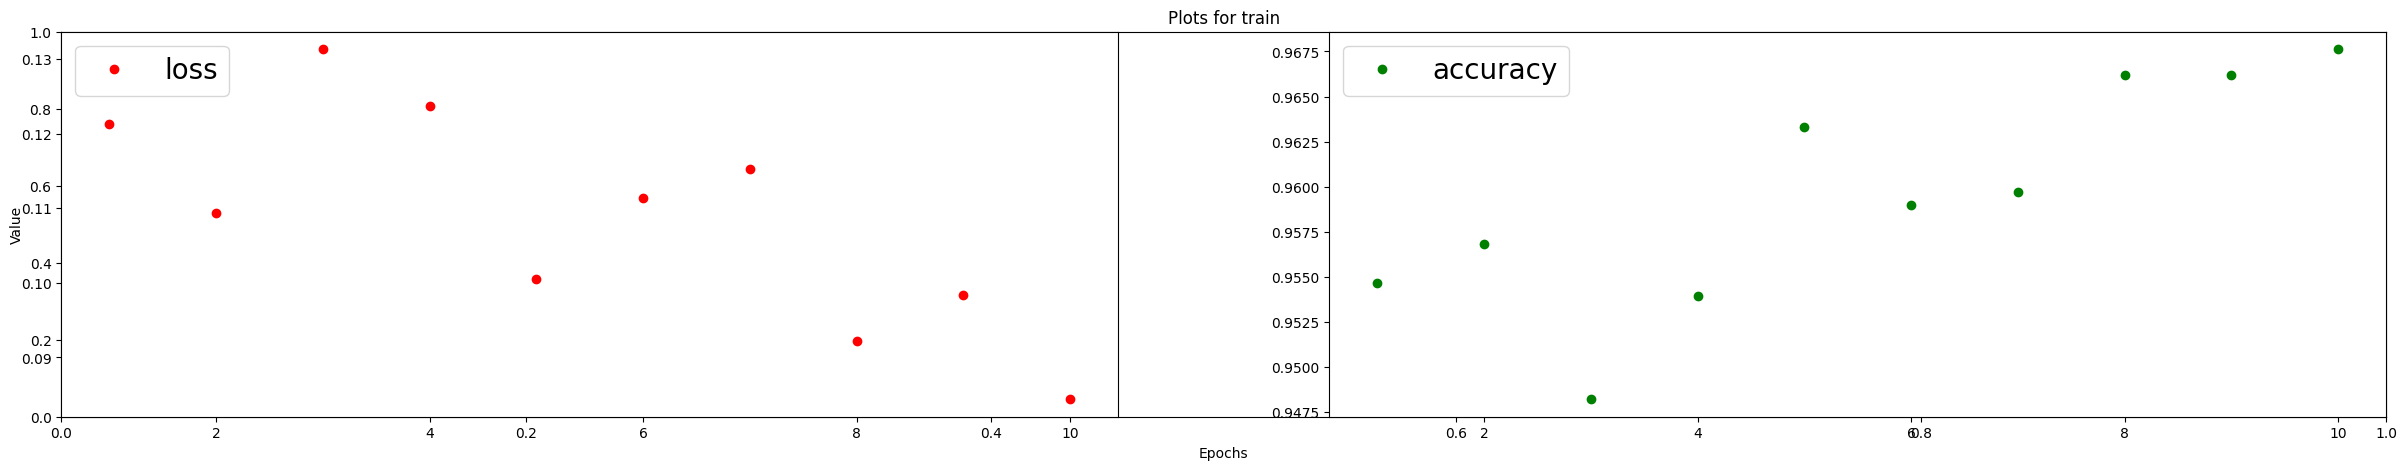

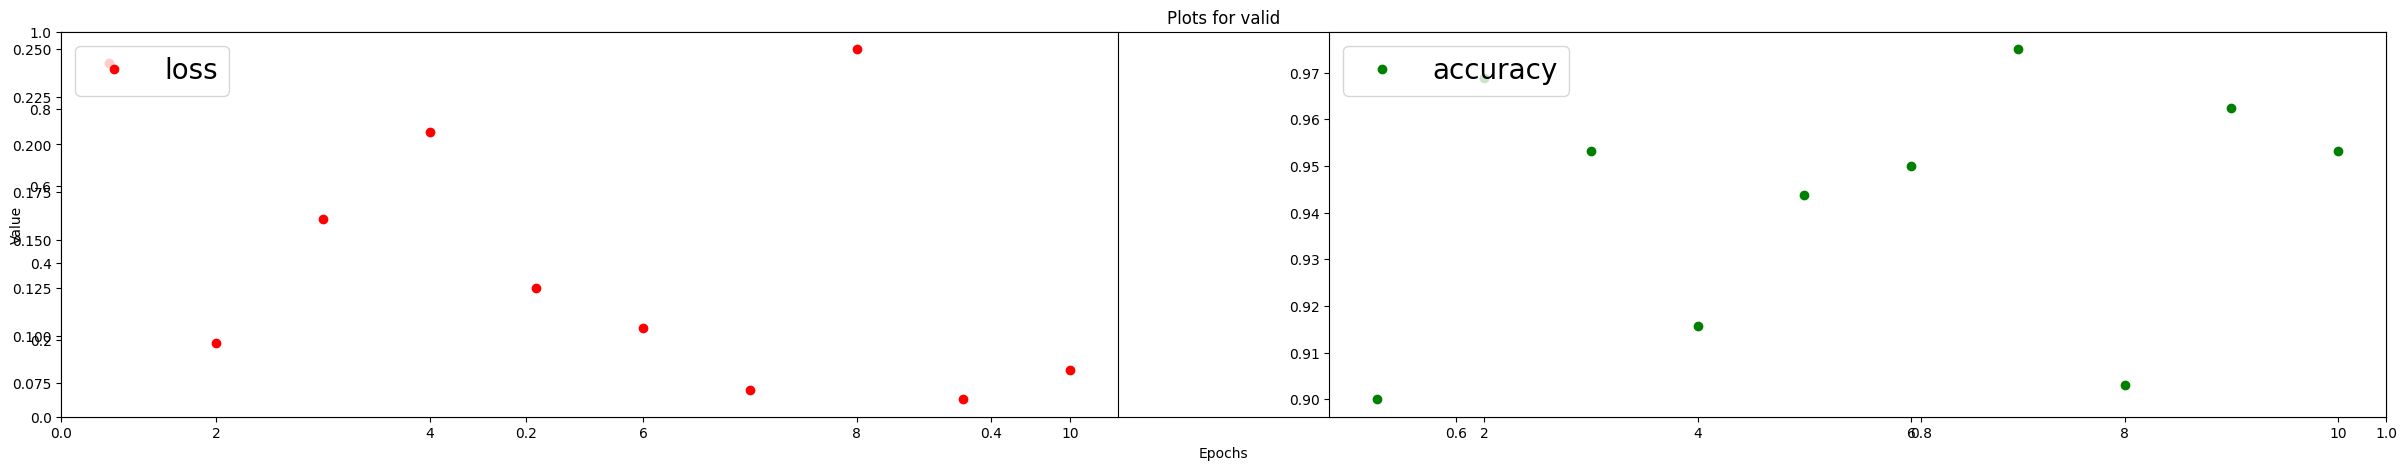

In [10]:
print('Learning rate: 0.0005, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 10
Epoch : 1, train accuracy : 0.9690633416175842, train loss : 0.09450861811637878
Epoch : 1, val_accuracy : 0.9406249523162842, val_loss : 0.12885670363903046
Epoch : 2, train accuracy : 0.96474689245224, train loss : 0.10503152012825012
Epoch : 2, val_accuracy : 0.9562499523162842, val_loss : 0.1165425106883049
Epoch : 3, train accuracy : 0.9647470116615295, train loss : 0.0870952233672142
Epoch : 3, val_accuracy : 0.96875, val_loss : 0.0931587666273117
Epoch : 4, train accuracy : 0.9625887274742126, train loss : 0.1036648079752922
Epoch : 4, val_accuracy : 0.9468749761581421, val_loss : 0.1348842978477478
Epoch : 5, train accuracy : 0.9618692398071289, train loss : 0.08843928575515747
Epoch : 5, val_accuracy : 0.9874999523162842, val_loss : 0.04543269798159599
Epoch : 6, train accuracy : 0.9611499905586243, train loss : 0.10315635800361633
Epoch : 6, val_accuracy : 0.96875, val_loss : 0.1046031191945076
Epoch : 7, train accuracy : 0.96114975214004

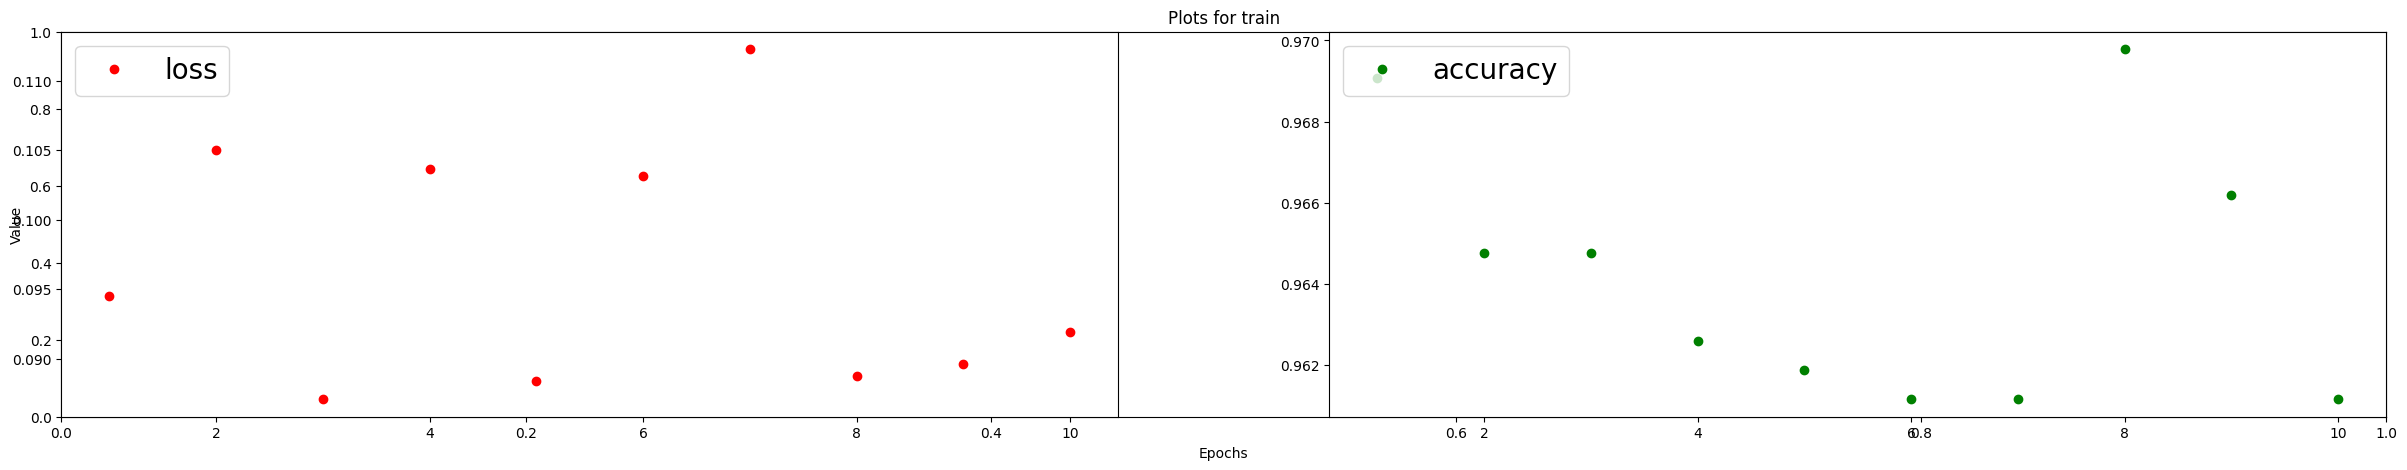

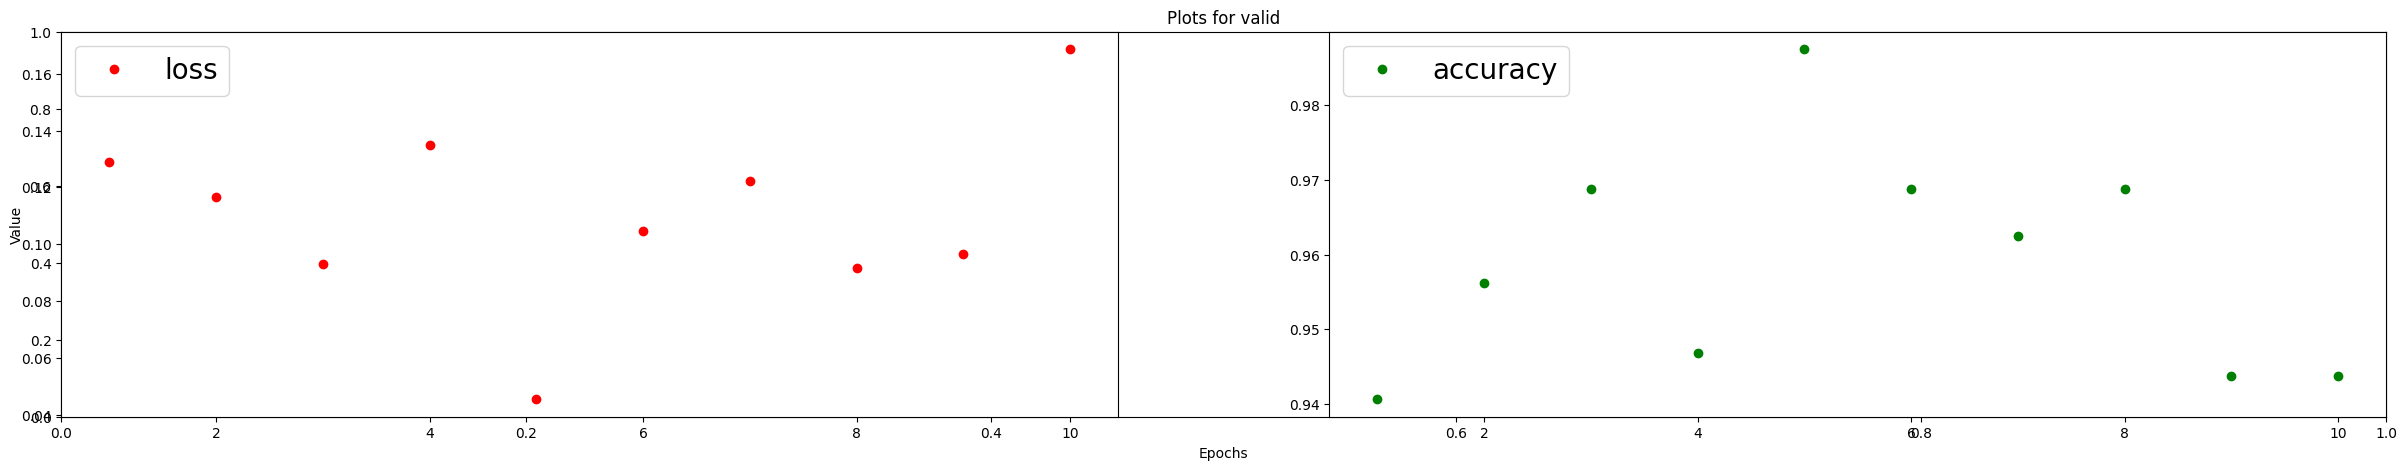

In [11]:
print('Learning rate: 0.0007, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 20
Epoch : 1, train accuracy : 0.9657150506973267, train loss : 0.08206383883953094
Epoch : 1, val_accuracy : 0.9785714149475098, val_loss : 0.051169443875551224
Epoch : 2, train accuracy : 0.9628577828407288, train loss : 0.09296923130750656
Epoch : 2, val_accuracy : 0.987500011920929, val_loss : 0.04859999194741249
Epoch : 3, train accuracy : 0.9735721945762634, train loss : 0.07567902654409409
Epoch : 3, val_accuracy : 0.956250011920929, val_loss : 0.10016410797834396
Epoch : 4, train accuracy : 0.9785721302032471, train loss : 0.06315194070339203
Epoch : 4, val_accuracy : 0.9750000238418579, val_loss : 0.07836247980594635
Epoch : 5, train accuracy : 0.96000075340271, train loss : 0.08604776114225388
Epoch : 5, val_accuracy : 0.96875, val_loss : 0.08478127419948578
Epoch : 6, train accuracy : 0.9550005793571472, train loss : 0.12751370668411255
Epoch : 6, val_accuracy : 0.9562499523162842, val_loss : 0.08405519276857376
Epoch : 7, train accuracy : 0

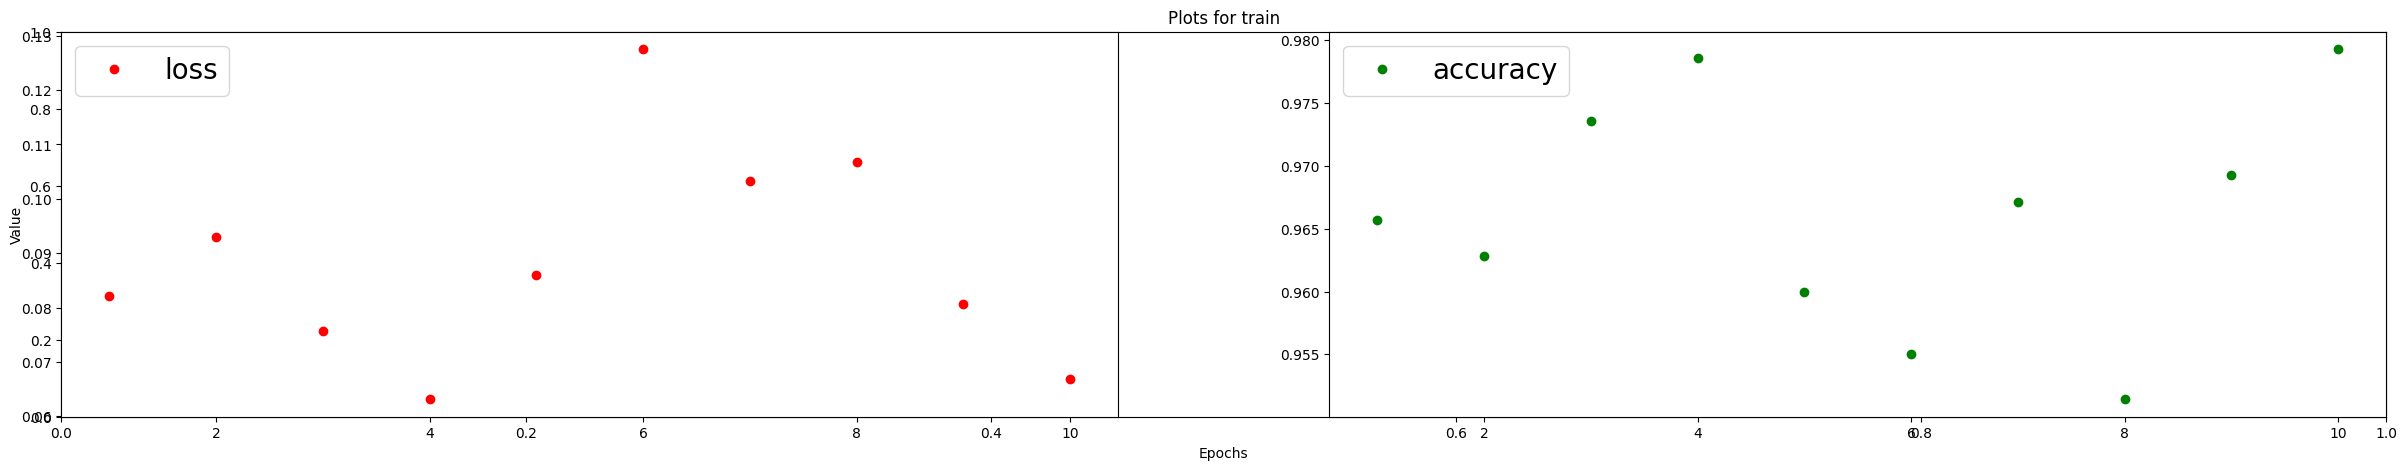

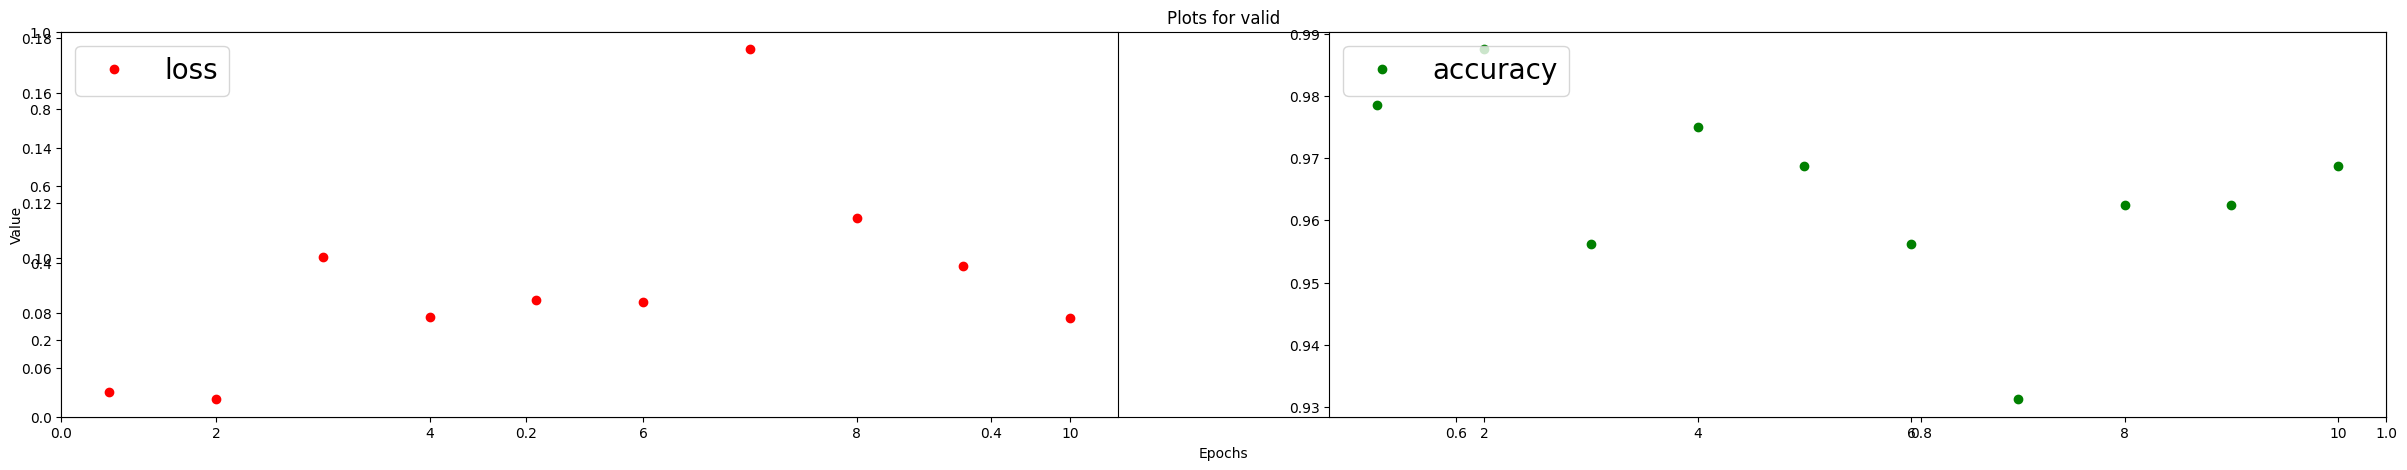

In [12]:
print('Learning rate: 0.001, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 20
Epoch : 1, train accuracy : 0.970000684261322, train loss : 0.08251577615737915
Epoch : 1, val_accuracy : 0.9687500596046448, val_loss : 0.08525090664625168
Epoch : 2, train accuracy : 0.976429283618927, train loss : 0.0662299171090126
Epoch : 2, val_accuracy : 0.9687500596046448, val_loss : 0.0969700738787651
Epoch : 3, train accuracy : 0.9671435952186584, train loss : 0.10012757778167725
Epoch : 3, val_accuracy : 0.96875, val_loss : 0.08822215348482132
Epoch : 4, train accuracy : 0.9650006890296936, train loss : 0.08587757498025894
Epoch : 4, val_accuracy : 0.9723213911056519, val_loss : 0.06358791142702103
Epoch : 5, train accuracy : 0.9814294576644897, train loss : 0.05657374486327171
Epoch : 5, val_accuracy : 0.9750000238418579, val_loss : 0.07955821603536606
Epoch : 6, train accuracy : 0.9707150459289551, train loss : 0.06556954234838486
Epoch : 6, val_accuracy : 0.9723213911056519, val_loss : 0.05280502140522003
Epoch : 7, train accuracy : 0

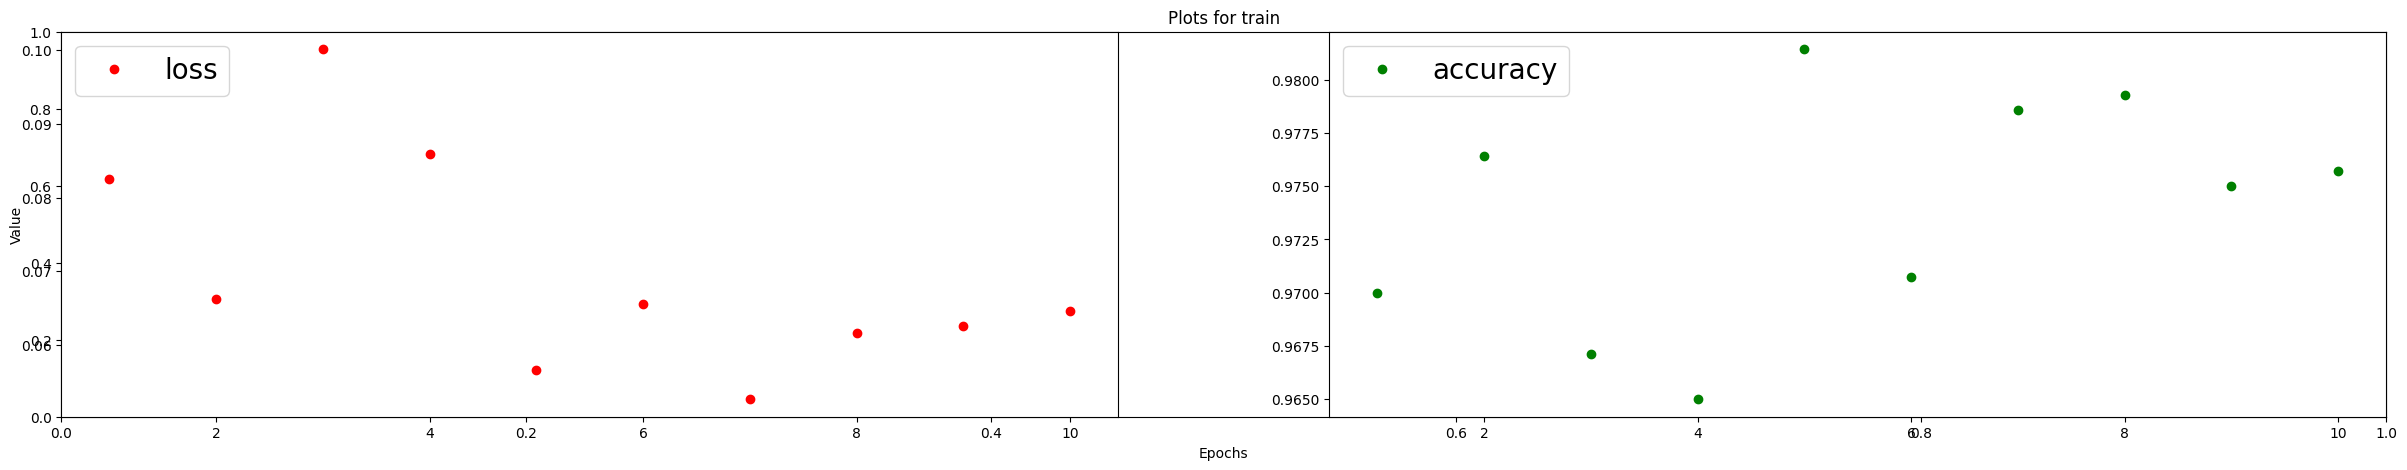

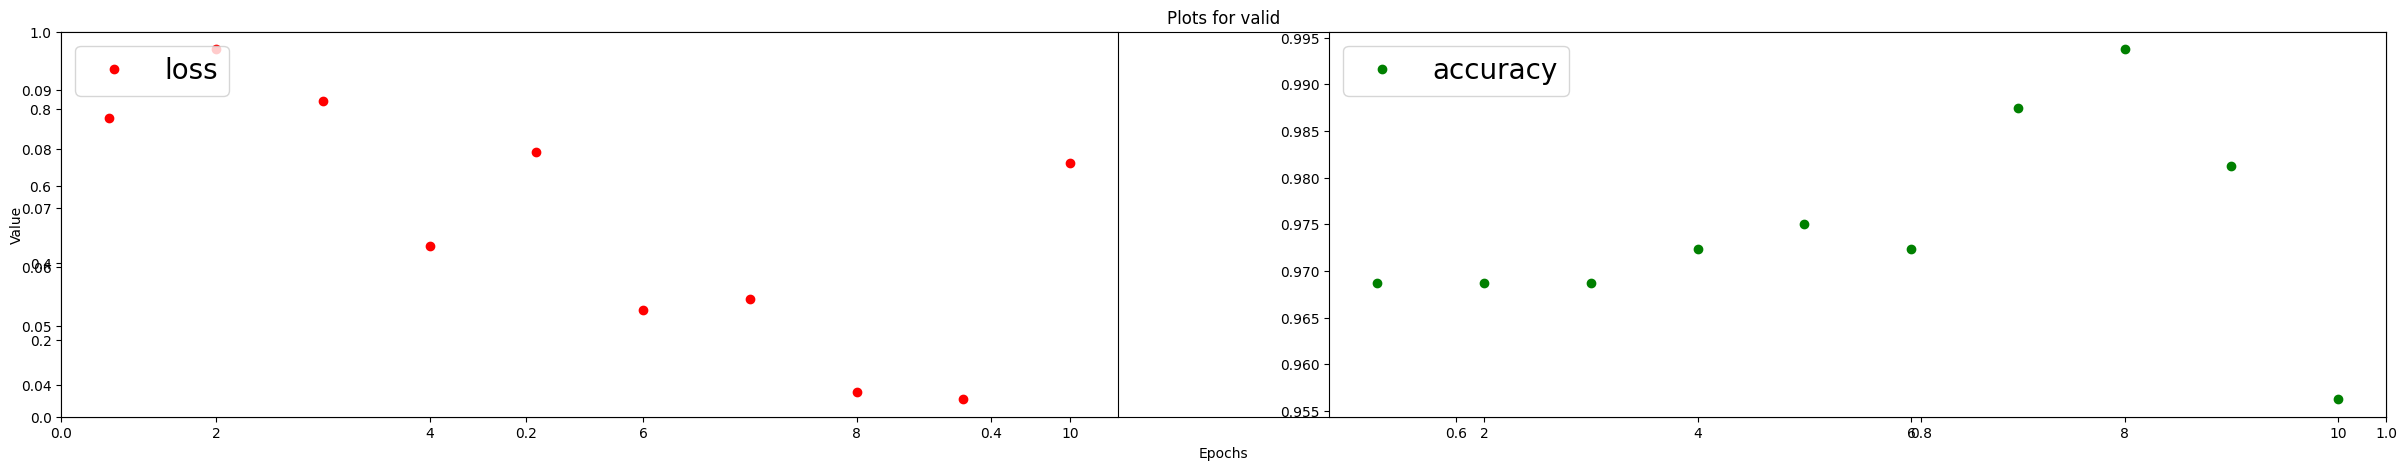

In [13]:
print('Learning rate: 0.0005, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 20
Epoch : 1, train accuracy : 0.9742864966392517, train loss : 0.07068731635808945
Epoch : 1, val_accuracy : 0.9321428537368774, val_loss : 0.15134502947330475
Epoch : 2, train accuracy : 0.9785721898078918, train loss : 0.06031901761889458
Epoch : 2, val_accuracy : 0.9749999642372131, val_loss : 0.07923728972673416
Epoch : 3, train accuracy : 0.9742864370346069, train loss : 0.06538157165050507
Epoch : 3, val_accuracy : 0.9687499403953552, val_loss : 0.061540637165308
Epoch : 4, train accuracy : 0.9814294576644897, train loss : 0.058357298374176025
Epoch : 4, val_accuracy : 0.978571355342865, val_loss : 0.06202638894319534
Epoch : 5, train accuracy : 0.9714292883872986, train loss : 0.07030796259641647
Epoch : 5, val_accuracy : 0.9812499284744263, val_loss : 0.0651753768324852
Epoch : 6, train accuracy : 0.9778580069541931, train loss : 0.06668726354837418
Epoch : 6, val_accuracy : 0.987500011920929, val_loss : 0.03131513670086861
Epoch : 7, train a

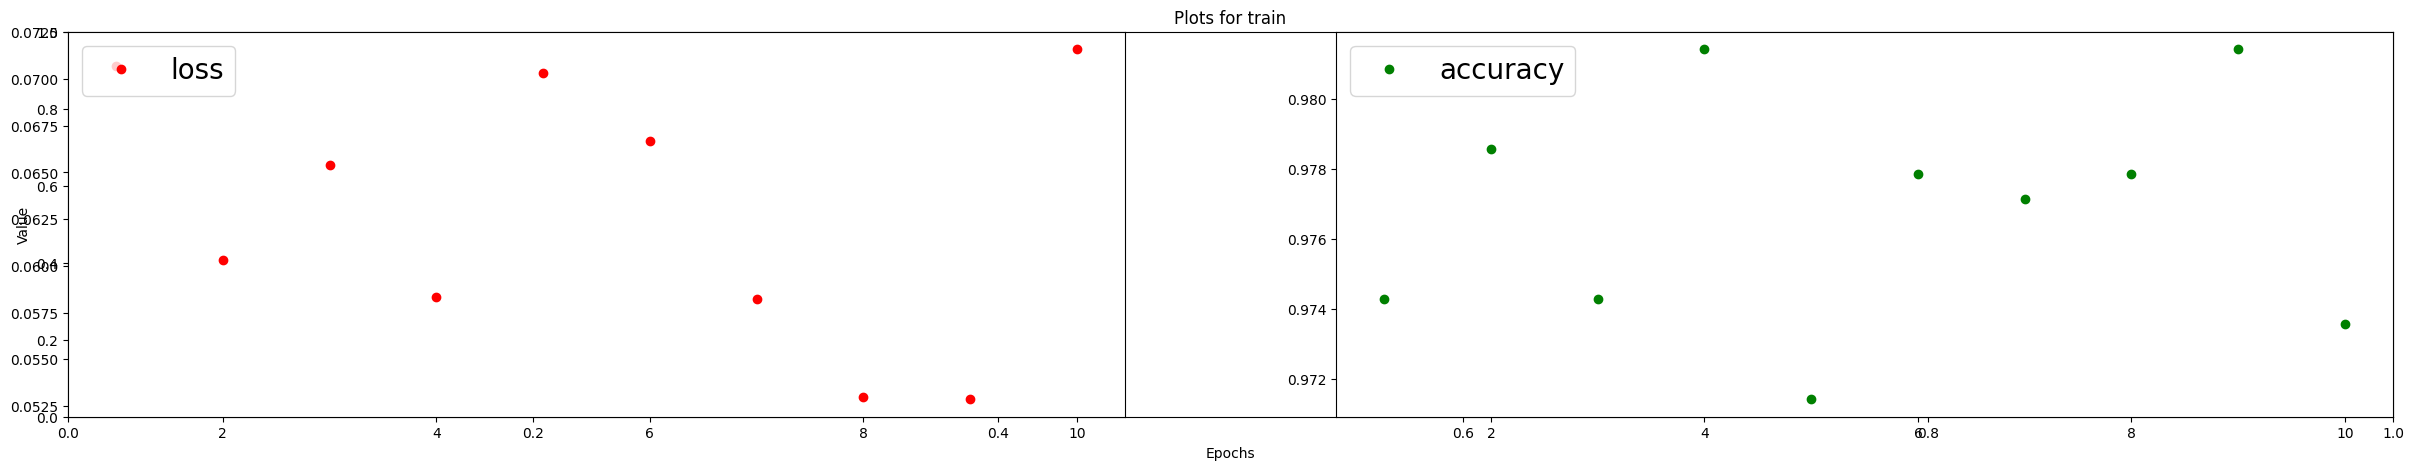

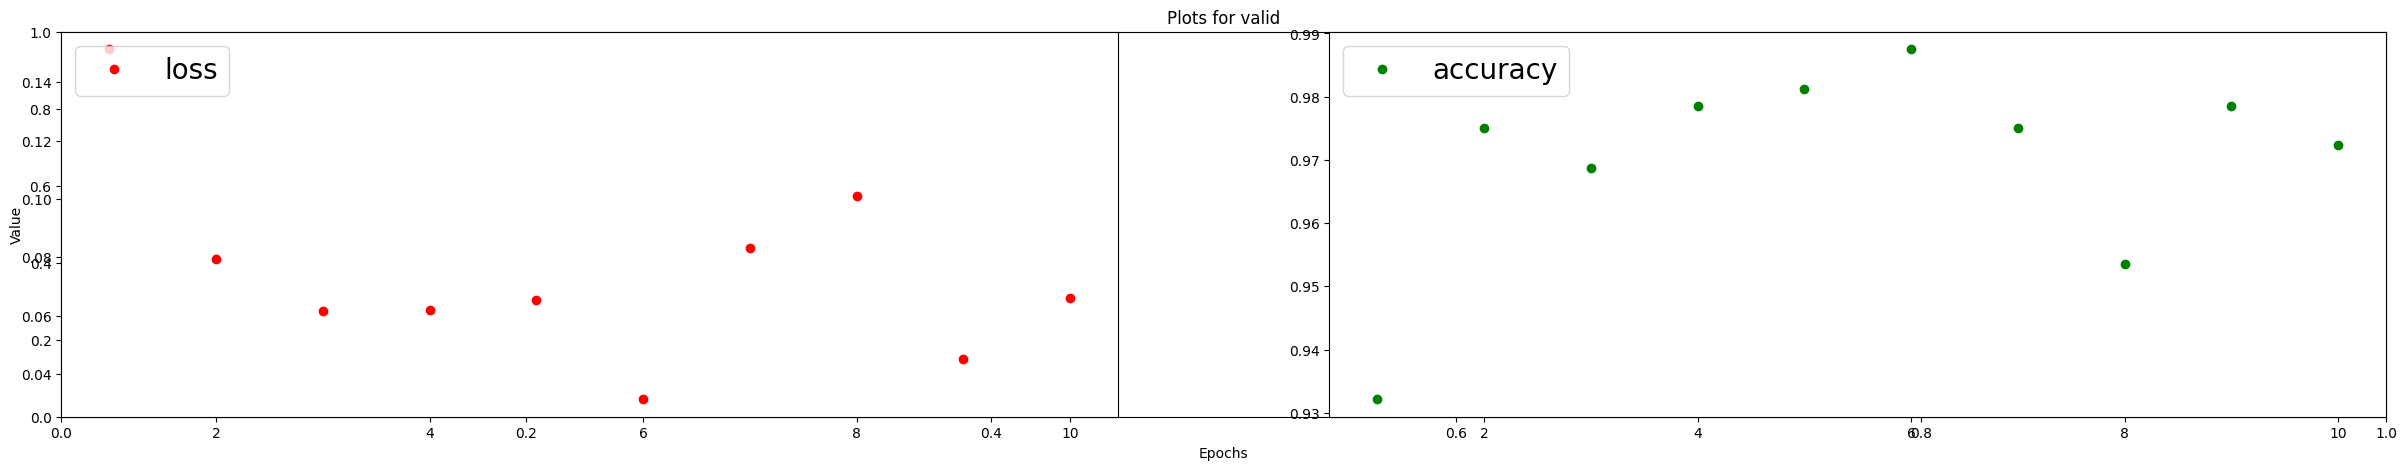

In [14]:
print('Learning rate: 0.0007, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 50
Epoch : 1, train accuracy : 0.9788839817047119, train loss : 0.05010782182216644
Epoch : 1, val_accuracy : 0.9800000190734863, val_loss : 0.055878523737192154
Epoch : 2, train accuracy : 0.9853125810623169, train loss : 0.044958390295505524
Epoch : 2, val_accuracy : 0.9850000143051147, val_loss : 0.0381457693874836
Epoch : 3, train accuracy : 0.9781697988510132, train loss : 0.05351424589753151
Epoch : 3, val_accuracy : 0.9850000143051147, val_loss : 0.03371682018041611
Epoch : 4, train accuracy : 0.9807143211364746, train loss : 0.05369864031672478
Epoch : 4, val_accuracy : 0.9225000143051147, val_loss : 0.08745013177394867
Epoch : 5, train accuracy : 0.9785714745521545, train loss : 0.05100780725479126
Epoch : 5, val_accuracy : 0.9225000143051147, val_loss : 0.11502419412136078
Epoch : 6, train accuracy : 0.9774553775787354, train loss : 0.06023583561182022
Epoch : 6, val_accuracy : 0.8650000095367432, val_loss : 0.2177797257900238
Epoch : 7, trai

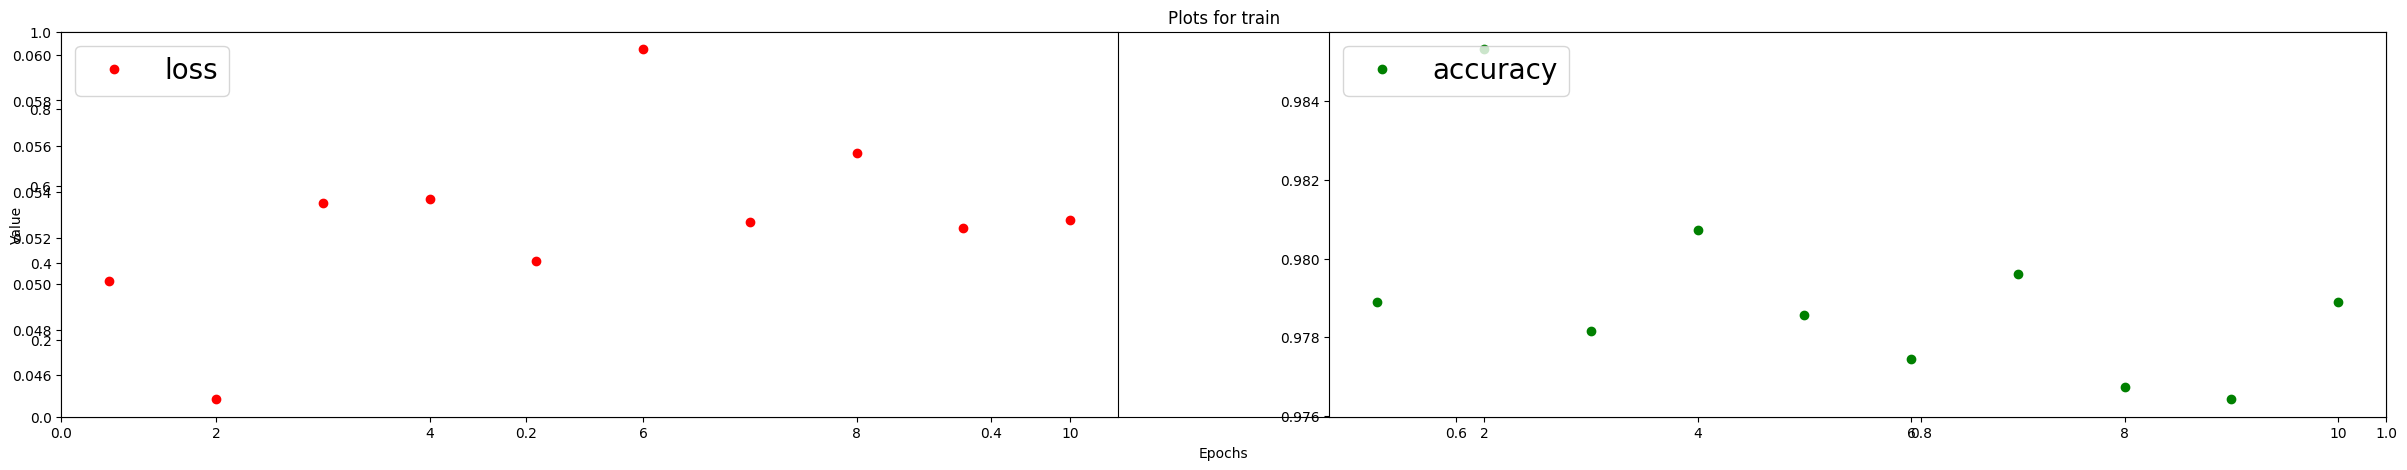

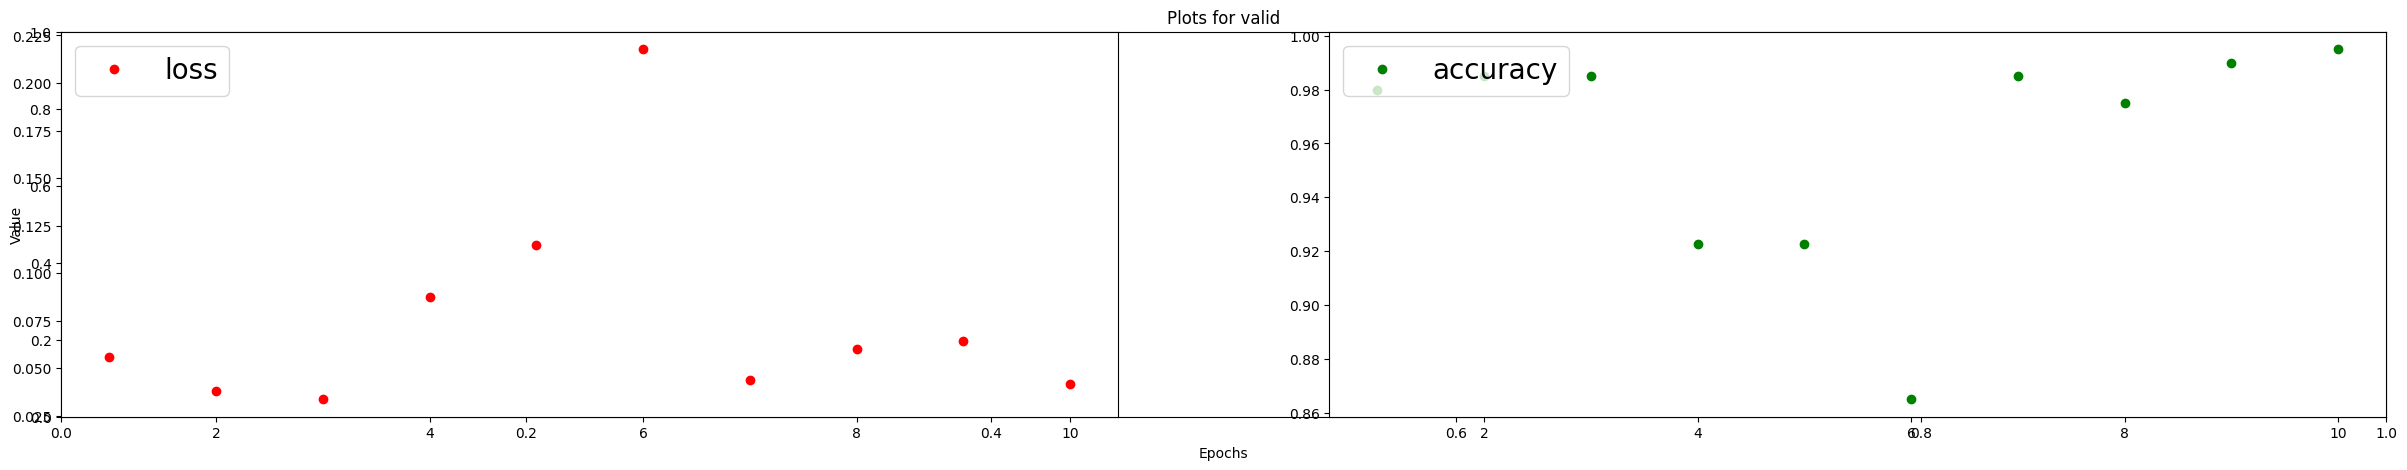

In [15]:
print('Learning rate: 0.001, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 50
Epoch : 1, train accuracy : 0.9764286279678345, train loss : 0.04962340369820595
Epoch : 1, val_accuracy : 0.9950000047683716, val_loss : 0.046633895486593246
Epoch : 2, train accuracy : 0.980312705039978, train loss : 0.04724341258406639
Epoch : 2, val_accuracy : 0.9950000047683716, val_loss : 0.023488884791731834
Epoch : 3, train accuracy : 0.9807143211364746, train loss : 0.049152977764606476
Epoch : 3, val_accuracy : 0.9325000047683716, val_loss : 0.2656249403953552
Epoch : 4, train accuracy : 0.9785715937614441, train loss : 0.0474262498319149
Epoch : 4, val_accuracy : 0.9225000143051147, val_loss : 0.3494867980480194
Epoch : 5, train accuracy : 0.9871428608894348, train loss : 0.03681518882513046
Epoch : 5, val_accuracy : 0.9750000238418579, val_loss : 0.05392468720674515
Epoch : 6, train accuracy : 0.9900000691413879, train loss : 0.030898235738277435
Epoch : 6, val_accuracy : 1.0, val_loss : 0.02440463751554489
Epoch : 7, train accuracy : 0

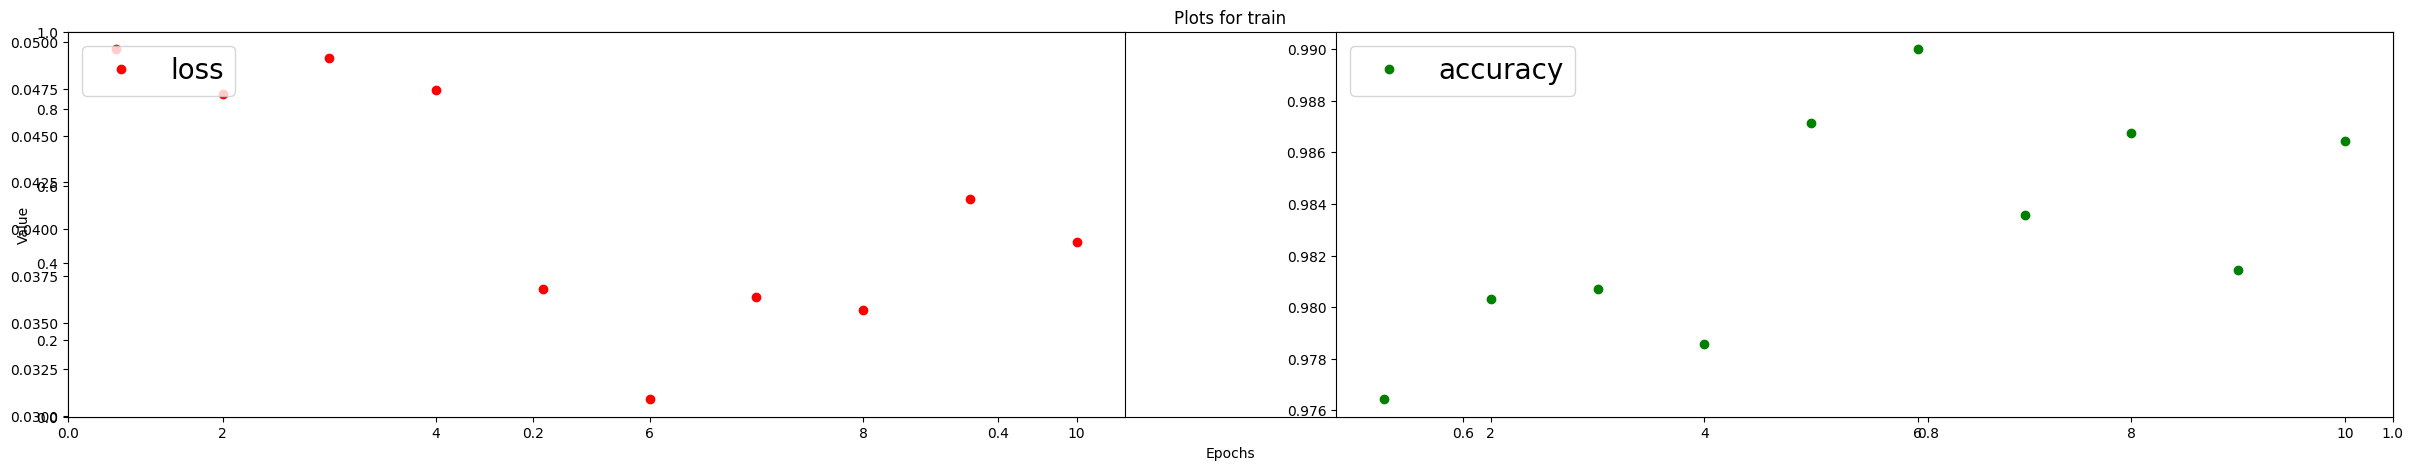

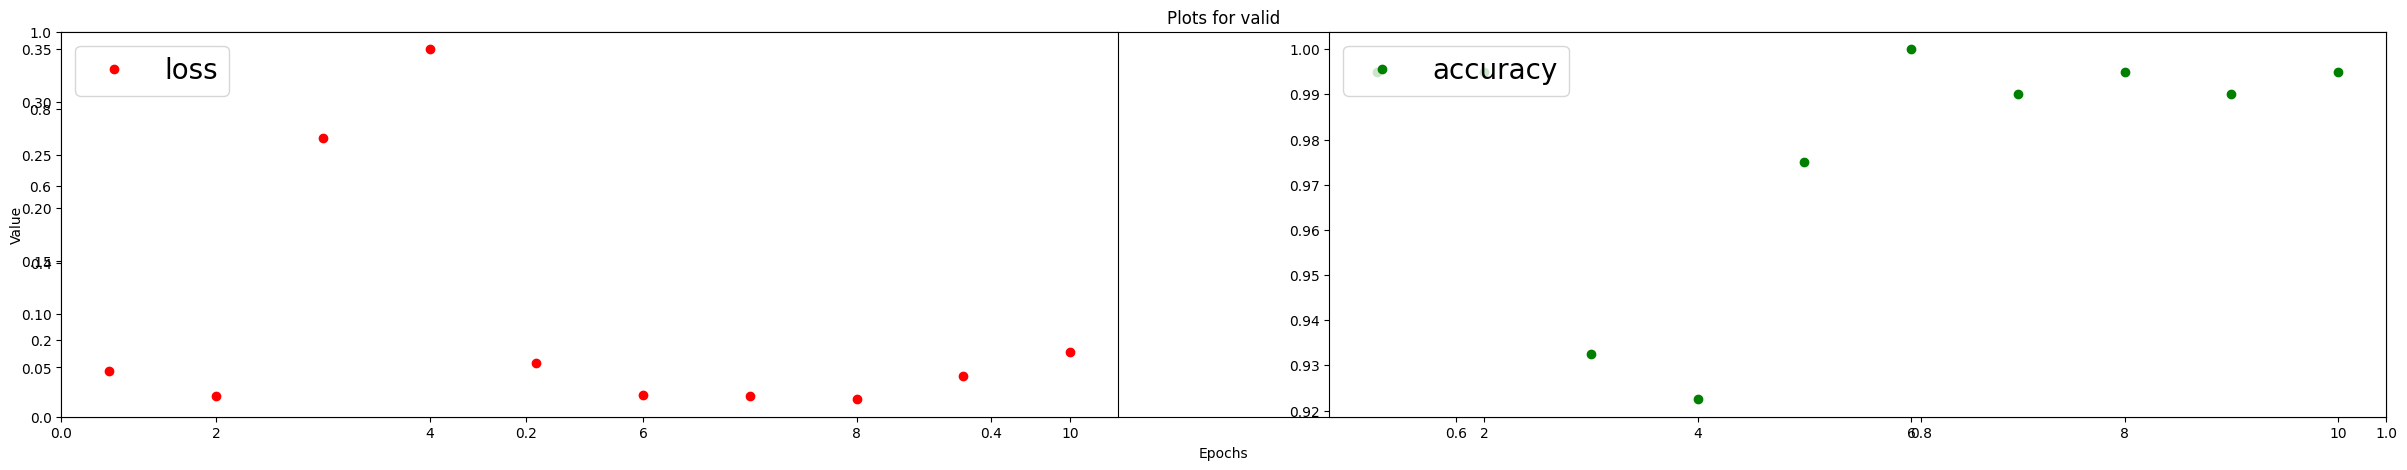

In [16]:
print('Learning rate: 0.0005, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 50
Epoch : 1, train accuracy : 0.9817411303520203, train loss : 0.049488164484500885
Epoch : 1, val_accuracy : 0.9900000095367432, val_loss : 0.033348262310028076
Epoch : 2, train accuracy : 0.9860268831253052, train loss : 0.03725849837064743
Epoch : 2, val_accuracy : 0.9700000286102295, val_loss : 0.06624074280261993
Epoch : 3, train accuracy : 0.9776785969734192, train loss : 0.0484338216483593
Epoch : 3, val_accuracy : 0.9800000190734863, val_loss : 0.05743912607431412
Epoch : 4, train accuracy : 0.989598274230957, train loss : 0.031140536069869995
Epoch : 4, val_accuracy : 0.9850000143051147, val_loss : 0.03129052370786667
Epoch : 5, train accuracy : 0.974598228931427, train loss : 0.05744168162345886
Epoch : 5, val_accuracy : 0.9700000286102295, val_loss : 0.07638737559318542
Epoch : 6, train accuracy : 0.9792857766151428, train loss : 0.052284400910139084
Epoch : 6, val_accuracy : 0.9900000095367432, val_loss : 0.03782602399587631
Epoch : 7, tr

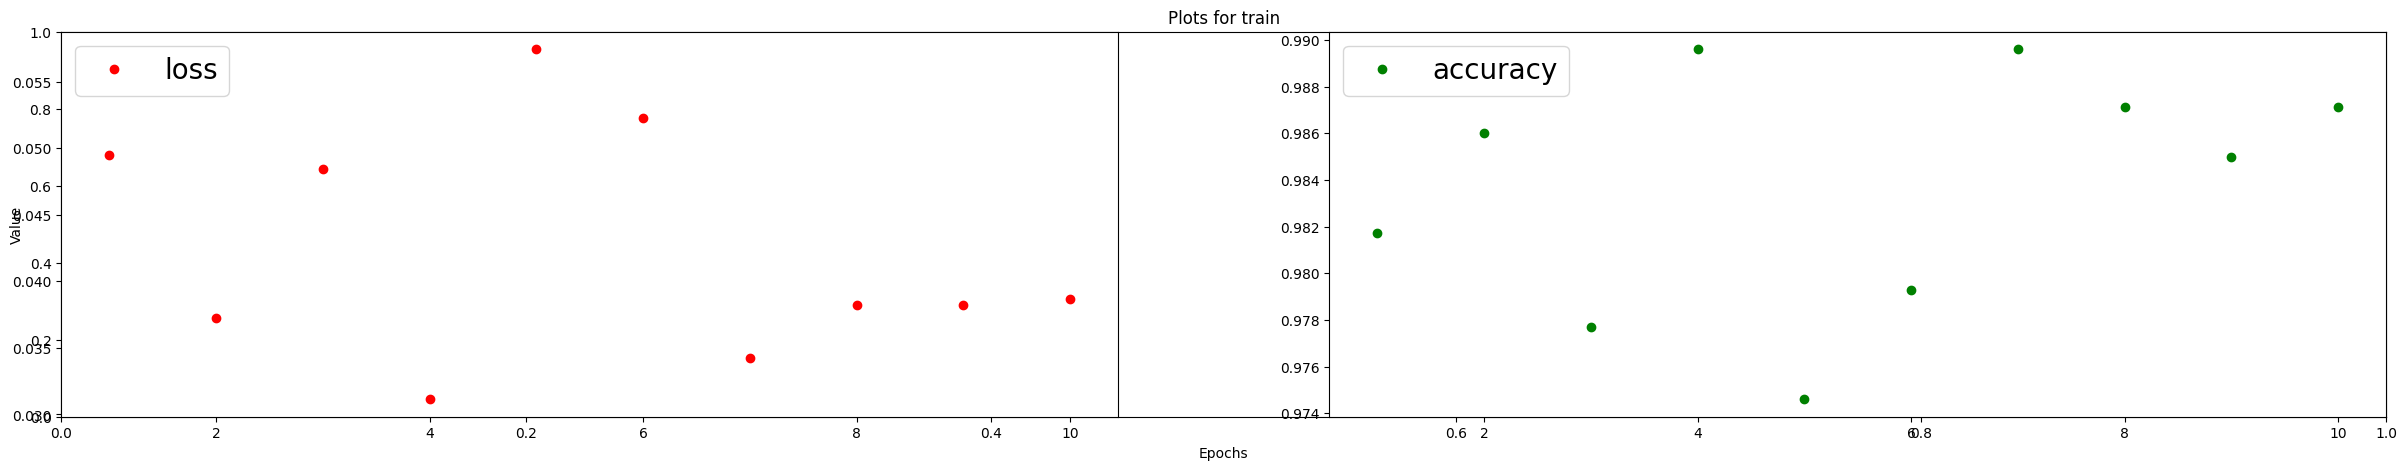

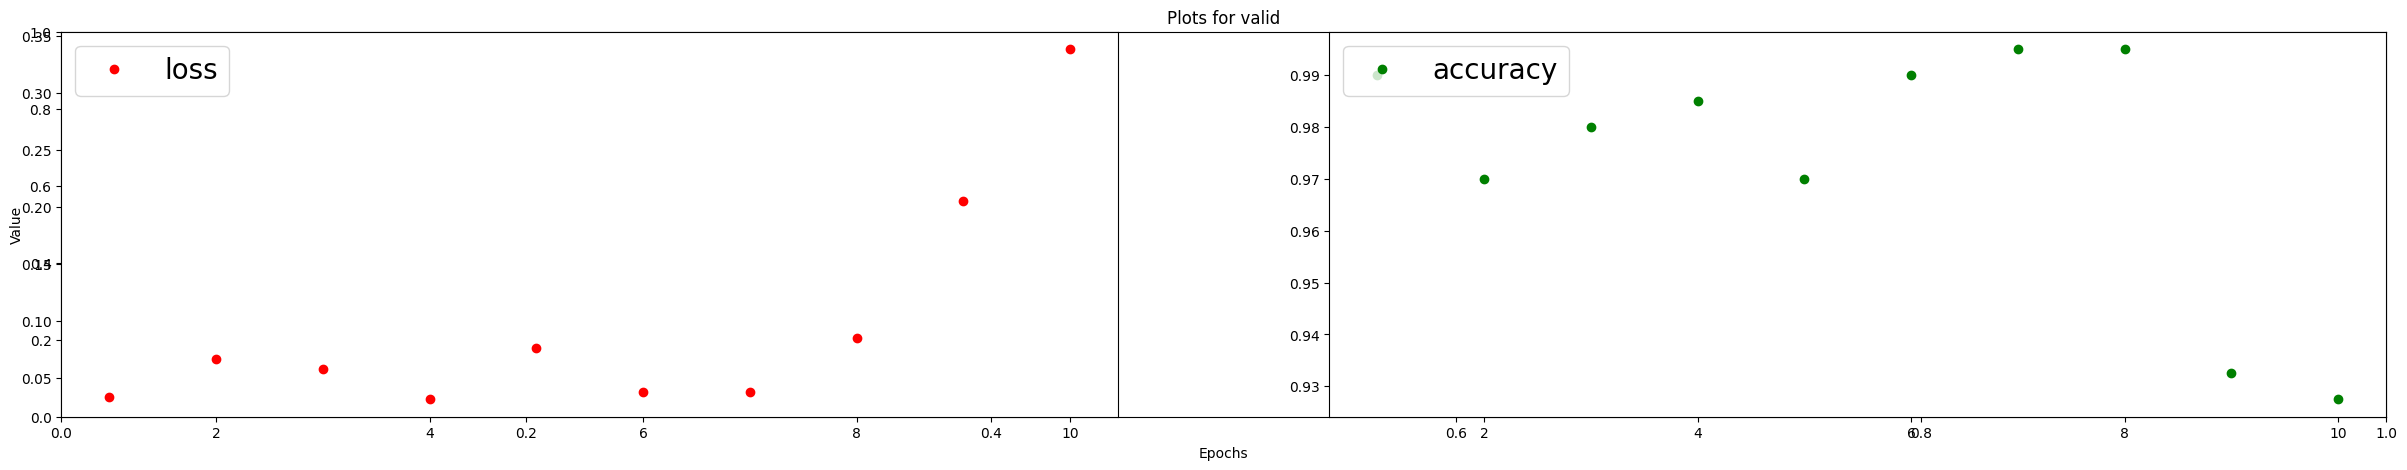

In [17]:
print('Learning rate: 0.0007, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)